## Code to generate tradingview images from chartimg api

In [9]:
import requests  # For making API calls
from datetime import datetime  # For date calculations
from IPython.display import Image, display  # For displaying images in the notebook
import os  # For file operations

# Define the API key and endpoint URL for the CHART-IMG REST API
API_KEY = "RHHLaR7k9h3p3mww6idK18S9ycvX7Pwt4p48IlAn"  # Replace with your actual API key
ENDPOINT_URL = "https://api.chart-img.com/v2/tradingview/advanced-chart"  # Base endpoint for the API

# Ensure the 'images' folder exists
os.makedirs("images", exist_ok=True)

# Function to generate the payload
def create_payload(symbol, interval, period, studies):
    return {
        "symbol": symbol,
        "interval": interval,
        "range": period,
        "studies": studies
    }

# Function to save the chart image
def save_chart_image(response, symbol, interval):
    today_str = datetime.now().strftime("%Y-%m-%d")
    image_filename = f"images/{symbol.replace(':', '_')}_{interval}_{today_str}.png"
    
    with open(image_filename, "wb") as file:
        file.write(response.content)
    return image_filename

# Function to display the chart image
def display_chart_image(image_filename):
    if os.path.exists(image_filename):
        display(Image(filename=image_filename))
    else:
        print(f"Chart image file '{image_filename}' not found.")

# Main function to generate the chart images
def generate_images(symbol):
    headers = {
        "x-api-key": API_KEY,
        "content-type": "application/json"
    }
    
    # Configuration 1: 1D interval, 6M period, 30SMA (light blue)
    studies_1 = [
        {
            "name": "Volume",
            "forceOverlay": True
        },
        {
            "name": "Moving Average",
            "input": {
                "length": 30
            },
            "override": {
                "Plot.color": "rgba(173,216,230,1)"  # Light blue color
            }
        }
    ]
    payload_1 = create_payload(symbol, "1D", "6M", studies_1)
    print("Request Payload for 1D, 6M:", payload_1)  # Optional: For debugging
    
    response_1 = requests.post(ENDPOINT_URL, headers=headers, json=payload_1)
    if response_1.status_code == 200:
        image_filename_1 = save_chart_image(response_1, symbol, "1D")
        print(f"Chart image saved successfully as {image_filename_1}")
        display_chart_image(image_filename_1)
    else:
        print(f"Failed to fetch 1D chart. Status Code: {response_1.status_code}, Response: {response_1.text}")
    
    # Configuration 2: 1h interval, 3M period, 9 EMA (black) and 21 EMA (orange)
    studies_2 = [
        {
            "name": "Volume",
            "forceOverlay": True
        },
        {
            "name": "Moving Average Exponential",
            "input": {
                "length": 9
            },
            "override": {
                "Plot.color": "rgba(0,0,0,1)"  # Black color
            }
        },
        {
            "name": "Moving Average Exponential",
            "input": {
                "length": 21
            },
            "override": {
                "Plot.color": "rgba(255,165,0,1)"  # Orange color
            }
        }
    ]
    payload_2 = create_payload(symbol, "1h", "1M", studies_2)
    print("Request Payload for 1h, 3M:", payload_2)  # Optional: For debugging
    
    response_2 = requests.post(ENDPOINT_URL, headers=headers, json=payload_2)
    if response_2.status_code == 200:
        image_filename_2 = save_chart_image(response_2, symbol, "1h")
        print(f"Chart image saved successfully as {image_filename_2}")
        display_chart_image(image_filename_2)
    else:
        print(f"Failed to fetch 1h chart. Status Code: {response_2.status_code}, Response: {response_2.text}")


Request Payload for 1D, 6M: {'symbol': 'NSE:NIFTY', 'interval': '1D', 'range': '6M', 'studies': [{'name': 'Volume', 'forceOverlay': True}, {'name': 'Moving Average', 'input': {'length': 30}, 'override': {'Plot.color': 'rgba(173,216,230,1)'}}]}
Chart image saved successfully as images/NSE_NIFTY_1D_2025-09-08.png


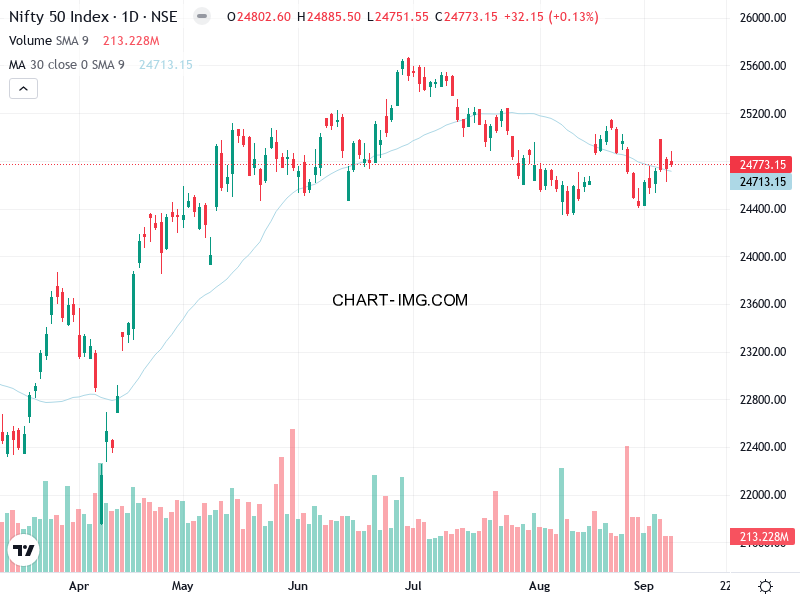

Request Payload for 1h, 3M: {'symbol': 'NSE:NIFTY', 'interval': '1h', 'range': '1M', 'studies': [{'name': 'Volume', 'forceOverlay': True}, {'name': 'Moving Average Exponential', 'input': {'length': 9}, 'override': {'Plot.color': 'rgba(0,0,0,1)'}}, {'name': 'Moving Average Exponential', 'input': {'length': 21}, 'override': {'Plot.color': 'rgba(255,165,0,1)'}}]}
Chart image saved successfully as images/NSE_NIFTY_1h_2025-09-08.png


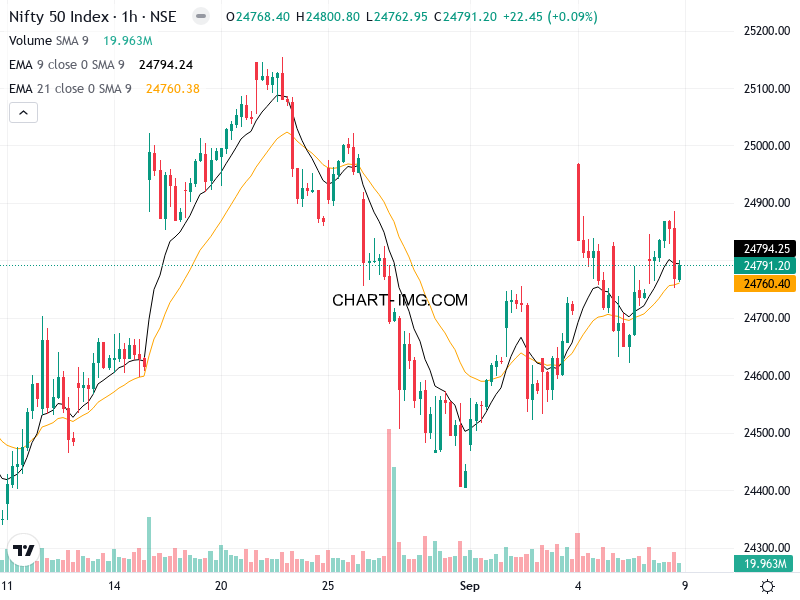

In [10]:
# Example usage
generate_images(symbol="NSE:NIFTY")

## Code to upload images to google drive and then to presentation automatically

In [13]:


from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from google.oauth2 import service_account

# Configuration
drive_SCOPES = ['https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/presentations']
drive_SERVICE_ACCOUNT_FILE = '/Volumes/Work/Coding/Automation/gsheet_auto_onlystockmarket8.json'
drive_PARENT_FOLDER_ID = "1jd6ztmZL1JlBTRh8uzvDS-bBoSojY0XQ"
PRESENTATION_ID = "1h6rz2eed078IJi4ouUhmaJem-4QooDZxe_izoWwqQoQ"

# Standard slide dimensions in points (for 16:9 aspect ratio)
SLIDE_WIDTH_PT = 720  # 10 inches * 72 points/inch
SLIDE_HEIGHT_PT = 405  # 5.625 inches * 72 points/inch

def authenticate():
    """Authenticate and return credentials for Google APIs"""
    creds = service_account.Credentials.from_service_account_file(
        drive_SERVICE_ACCOUNT_FILE, scopes=drive_SCOPES)
    return creds

def upload_image_to_drive(image_path):
    """Upload image to Google Drive and make it publicly accessible"""
    file_metadata = {
        'name': image_path.split('/')[-1],
        'parents': [drive_PARENT_FOLDER_ID]
    }
    
    creds = authenticate()
    drive_service = build('drive', 'v3', credentials=creds)

    media = MediaFileUpload(image_path, mimetype='image/png')
    file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()
    
    file_id = file['id']
    print(f"File uploaded successfully. File ID: {file_id}")
    
    # Make the file publicly accessible
    permission = {
        'type': 'anyone',
        'role': 'reader'
    }
    drive_service.permissions().create(
        fileId=file_id,
        body=permission
    ).execute()
    print(f"File {file_id} is now publicly accessible")
    
    return file_id

def create_new_slide(presentation_id):
    """Create a new blank slide and return its page ID"""
    creds = authenticate()
    slides_service = build('slides', 'v1', credentials=creds)
    
    # Get current presentation to find insertion index
    presentation = slides_service.presentations().get(presentationId=presentation_id).execute()
    slides = presentation.get('slides', [])
    
    # Create a new slide request
    slide_id = f"slide_{len(slides) + 1}"
    requests = [
        {
            'createSlide': {
                'objectId': slide_id,
                'insertionIndex': len(slides),  # Insert at the end
                'slideLayoutReference': {
                    'predefinedLayout': 'BLANK'
                }
            }
        }
    ]
    
    # Execute the requests
    body = {'requests': requests}
    response = slides_service.presentations().batchUpdate(
        presentationId=presentation_id, body=body).execute()
    
    print(f"Created new slide with ID: {slide_id}")
    return slide_id

def calculate_image_dimensions(image_percentage=0.90):
    """Calculate image dimensions as percentage of slide HEIGHT, maintaining aspect ratio"""
    # Calculate target height (90% of slide height)
    target_height = SLIDE_HEIGHT_PT * image_percentage
    
    return target_height

def get_image_aspect_ratio(image_path):
    """Get the aspect ratio of an image file"""
    try:
        from PIL import Image
        with Image.open(image_path) as img:
            width, height = img.size
            return width / height
    except ImportError:
        print("PIL not available, using default aspect ratio")
        return 16/9  # Default to 16:9
    except Exception as e:
        print(f"Could not get image dimensions: {e}")
        return 16/9  # Default to 16:9

def add_image_to_slide(file_id, presentation_id, page_id, image_path, image_percentage=0.90, title_text=""):
    """Add image from Drive to a specific slide, sized to percentage of slide height"""
    # Generate the public URL for the image
    image_url = f"https://drive.google.com/uc?export=download&id={file_id}"
    
    # Get image aspect ratio
    image_aspect_ratio = get_image_aspect_ratio(image_path)
    
    # Calculate dimensions based on slide height percentage
    target_height = calculate_image_dimensions(image_percentage)
    final_height = target_height
    final_width = target_height * image_aspect_ratio
    
    # Calculate positions - leave space on left for text
    text_box_width = 120  # Width for text box on left
    margin = 20  # Margin between text and image
    
    # Position image on the right side
    image_x_pos = text_box_width + margin
    image_y_pos = (SLIDE_HEIGHT_PT - final_height) / 2
    
    print(f"Image dimensions: {final_width:.1f} x {final_height:.1f} PT")
    print(f"Image position: ({image_x_pos:.1f}, {image_y_pos:.1f})")
    print(f"Slide coverage: {(final_width/SLIDE_WIDTH_PT)*100:.1f}% width, {(final_height/SLIDE_HEIGHT_PT)*100:.1f}% height")
    
    # Authenticate and build the Slides service
    creds = authenticate()
    slides_service = build('slides', 'v1', credentials=creds)
    
    # Create requests list
    requests = []
    
    # Add text box if title is provided
    if title_text:
        text_box_id = f"textbox_{page_id}"
        # Create text box on the left side
        requests.append({
            'createShape': {
                'objectId': text_box_id,
                'shapeType': 'TEXT_BOX',
                'elementProperties': {
                    'pageObjectId': page_id,
                    'size': {
                        'width': {'magnitude': text_box_width, 'unit': 'PT'},
                        'height': {'magnitude': final_height, 'unit': 'PT'}
                    },
                    'transform': {
                        'scaleX': 1,
                        'scaleY': 1,
                        'translateX': 10,  # Small margin from left edge
                        'translateY': image_y_pos,  # Align with image
                        'unit': 'PT'
                    }
                }
            }
        })
        
        # Insert text into the text box
        requests.append({
            'insertText': {
                'objectId': text_box_id,
                'text': title_text
            }
        })
        
        # Format the text (Tahoma font, black color)
        requests.append({
            'updateTextStyle': {
                'objectId': text_box_id,
                'style': {
                    'fontFamily': 'Tahoma',
                    'fontSize': {
                        'magnitude': 14,
                        'unit': 'PT'
                    },
                    'foregroundColor': {
                        'opaqueColor': {
                            'rgbColor': {
                                'red': 0.0,
                                'green': 0.0,
                                'blue': 0.0
                            }
                        }
                    }
                },
                'fields': 'fontFamily,fontSize,foregroundColor'
            }
        })
        
        # Center align the text vertically and horizontally
        requests.append({
            'updateParagraphStyle': {
                'objectId': text_box_id,
                'style': {
                    'alignment': 'CENTER'
                },
                'fields': 'alignment'
            }
        })
    
    # Add the image
    requests.append({
        'createImage': {
            'url': image_url,
            'elementProperties': {
                'pageObjectId': page_id,
                'size': {
                    'width': {'magnitude': final_width, 'unit': 'PT'},
                    'height': {'magnitude': final_height, 'unit': 'PT'}
                },
                'transform': {
                    'scaleX': 1,
                    'scaleY': 1,
                    'translateX': image_x_pos,
                    'translateY': image_y_pos,
                    'unit': 'PT'
                }
            }
        }
    })
    
    # Execute the batch update request
    body = {'requests': requests}
    try:
        response = slides_service.presentations().batchUpdate(
            presentationId=presentation_id, body=body).execute()
        if title_text:
            print(f"✅ Image and text box added to slide {page_id}")
        else:
            print(f"✅ Image added to slide {page_id}")
        return response
    except Exception as e:
        print(f"❌ Error adding image to slide: {e}")
        return None

def get_or_create_target_slide(presentation_id, create_new=True):
    """Get existing slide 2 or create a new slide for the image"""
    creds = authenticate()
    slides_service = build('slides', 'v1', credentials=creds)
    
    # Get current slides
    presentation = slides_service.presentations().get(presentationId=presentation_id).execute()
    slides = presentation.get('slides', [])
    
    print(f"Presentation currently has {len(slides)} slide(s)")
    
    if create_new or len(slides) < 2:
        # Create a new slide
        page_id = create_new_slide(presentation_id)
        slide_number = len(slides) + 1
    else:
        # Use existing second slide
        page_id = slides[1]['objectId']  # Second slide (index 1)
        slide_number = 2
        print(f"Using existing slide 2 with ID: {page_id}")
    
    return page_id, slide_number

def upload_and_add_image(image_path, presentation_id, image_percentage=0.90, 
                        create_new_slide=True, title_text=""):
    """Complete workflow: upload image to Drive and add to appropriate slide"""
    try:
        # Step 1: Upload image to Drive
        file_id = upload_image_to_drive(image_path)
        
        # Step 2: Get or create target slide
        page_id, slide_number = get_or_create_target_slide(
            presentation_id, create_new_slide)
        
        # Step 3: Add image to slide with optional text box
        response = add_image_to_slide(file_id, presentation_id, page_id, 
                                    image_path, image_percentage, title_text)
        
        if response:
            print(f"✅ Image successfully added to slide {slide_number}!")
            return file_id, page_id
        else:
            print("❌ Failed to add image to presentation")
            return None, None
            
    except Exception as e:
        print(f"❌ Error in upload_and_add_image: {e}")
        return None, None



In [14]:
# Example usage
image_path = '/Volumes/Work/Coding/Github - Local/monthly_trades_tracking/images/NSE_NIFTY_1D_2025-09-08.png'

# Upload and add image - will create new slide if needed
file_id, page_id = upload_and_add_image(
    image_path=image_path,
    presentation_id=PRESENTATION_ID,
    image_percentage=0.90,         # 90% of slide height
    create_new_slide=True,         # Always create new slide
    title_text="NSE NIFTY\nAnalysis"  # Text for left side text box
)

if file_id:
    print(f"\n📊 Summary:")
    print(f"Drive file ID: {file_id}")
    print(f"Slide ID: {page_id}")
    print(f"Direct Drive link: https://drive.google.com/file/d/{file_id}/view")
    print(f"Presentation link: https://docs.google.com/presentation/d/{PRESENTATION_ID}/edit")

File uploaded successfully. File ID: 11ZRKMgPYsKMBHKBJaKUdBBRwoyYl_qaw
File 11ZRKMgPYsKMBHKBJaKUdBBRwoyYl_qaw is now publicly accessible
Presentation currently has 4 slide(s)
Created new slide with ID: slide_5
Image dimensions: 486.0 x 364.5 PT
Image position: (140.0, 20.2)
Slide coverage: 67.5% width, 90.0% height
✅ Image and text box added to slide slide_5
✅ Image successfully added to slide 5!

📊 Summary:
Drive file ID: 11ZRKMgPYsKMBHKBJaKUdBBRwoyYl_qaw
Slide ID: slide_5
Direct Drive link: https://drive.google.com/file/d/11ZRKMgPYsKMBHKBJaKUdBBRwoyYl_qaw/view
Presentation link: https://docs.google.com/presentation/d/1h6rz2eed078IJi4ouUhmaJem-4QooDZxe_izoWwqQoQ/edit


In [2]:
import requests  # For making API calls
from datetime import datetime  # For date calculations
from IPython.display import Image, display  # For displaying images in the notebook
import os  # For file operations
import time  # For adding delays between API calls

# Define the API key and endpoint URL for the CHART-IMG REST API
API_KEY = "RHHLaR7k9h3p3mww6idK18S9ycvX7Pwt4p48IlAn"  # Replace with your actual API key
ENDPOINT_URL = "https://api.chart-img.com/v2/tradingview/advanced-chart"  # Base endpoint for the API

# Ensure the 'images' folder exists
os.makedirs("images", exist_ok=True)

# Function to generate the payload
def create_payload(symbol, interval, period, studies):
    return {
        "symbol": symbol,
        "interval": interval,
        "range": period,
        "studies": studies
    }

# Function to save the chart image with new naming convention
def save_chart_image(response, symbol, interval, symbol_index, config_index):
    # Extract symbol name (remove exchange prefix)
    symbol_name = symbol.split(':')[-1] if ':' in symbol else symbol
    today_str = datetime.now().strftime("%Y-%m-%d")
    image_filename = f"images/{symbol_index}.{config_index} - {symbol_name}_{interval}_{today_str}.png"
    
    with open(image_filename, "wb") as file:
        file.write(response.content)
    return image_filename

# Function to display the chart image
def display_chart_image(image_filename):
    if os.path.exists(image_filename):
        display(Image(filename=image_filename))
    else:
        print(f"Chart image file '{image_filename}' not found.")

# Function to generate chart for a single configuration
def generate_single_chart(symbol, interval, period, studies, symbol_index, config_index, headers):
    payload = create_payload(symbol, interval, period, studies)
    print(f"Generating {interval} chart for {symbol}...")
    
    response = requests.post(ENDPOINT_URL, headers=headers, json=payload)
    
    if response.status_code == 200:
        image_filename = save_chart_image(response, symbol, interval, symbol_index, config_index)
        print(f"Chart image saved successfully as {image_filename}")
        # display_chart_image(image_filename)
        return True
    else:
        print(f"Failed to fetch {interval} chart for {symbol}. Status Code: {response.status_code}, Response: {response.text}")
        return False

# Main function to generate chart images for multiple symbols
def generate_images_batch(stocks):
    headers = {
        "x-api-key": API_KEY,
        "content-type": "application/json"
    }
    
    # Define chart configurations
    configurations = [
        {
            "interval": "1D",
            "period": "6M",
            "studies": [
                {
                    "name": "Volume",
                    "forceOverlay": True
                },
                {
                    "name": "Moving Average",
                    "input": {
                        "length": 30
                    },
                    "override": {
                        "Plot.color": "rgba(173,216,230,1)"  # Light blue color
                    }
                }
            ],
            "config_index": 1
        },
        {
            "interval": "1W",
            "period": "5Y",
            "studies": [
                {
                    "name": "Volume",
                    "forceOverlay": True
                },
                {
                    "name": "Moving Average",
                    "input": {
                        "length": 50
                    },
                    "override": {
                        "Plot.color": "rgba(255,0,0,1)"  # Light red color
                    }
                }
            ],
            "config_index": 2
        },
        {
            "interval": "1M",
            "period": "ALL",
            "studies": [
                {
                    "name": "Volume",
                    "forceOverlay": True
                }
            ],
            "config_index": 3
        }
    ]
    
    # Process each symbol
    for symbol_index, symbol in enumerate(stocks, 1):
        print(f"\n--- Processing Symbol {symbol_index}: {symbol} ---")
        
        # Process each configuration for the current symbol
        for config in configurations:
            success = generate_single_chart(
                symbol=symbol,
                interval=config["interval"],
                period=config["period"],
                studies=config["studies"],
                symbol_index=symbol_index,
                config_index=config["config_index"],
                headers=headers
            )
            
            # Add a small delay between API calls to avoid rate limiting
            if success:
                time.sleep(1)  # 1 second delay
        
        print(f"Completed processing {symbol}")
        print("-" * 50)




--- Processing Symbol 1: NSE:NIFTY ---
Generating 1D chart for NSE:NIFTY...
Chart image saved successfully as images/1.1 - NIFTY_1D_2025-09-09.png


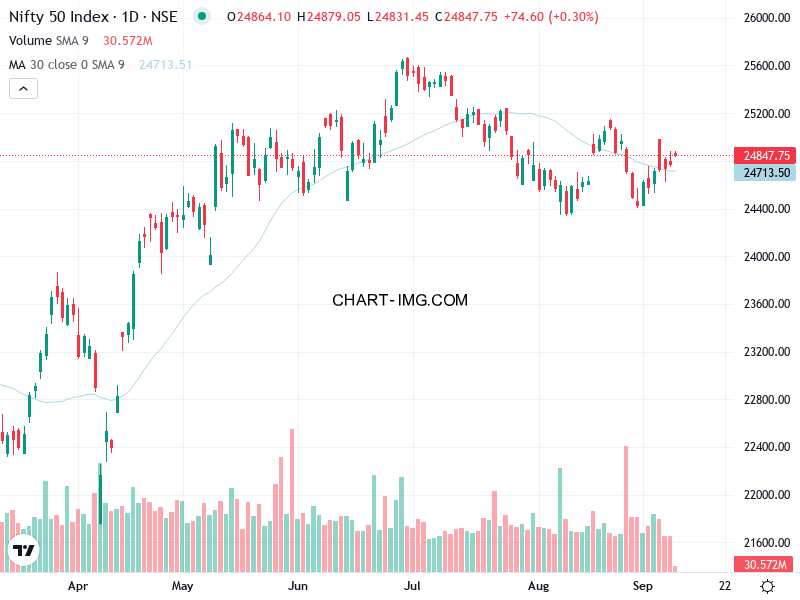

Generating 1W chart for NSE:NIFTY...
Chart image saved successfully as images/1.2 - NIFTY_1W_2025-09-09.png


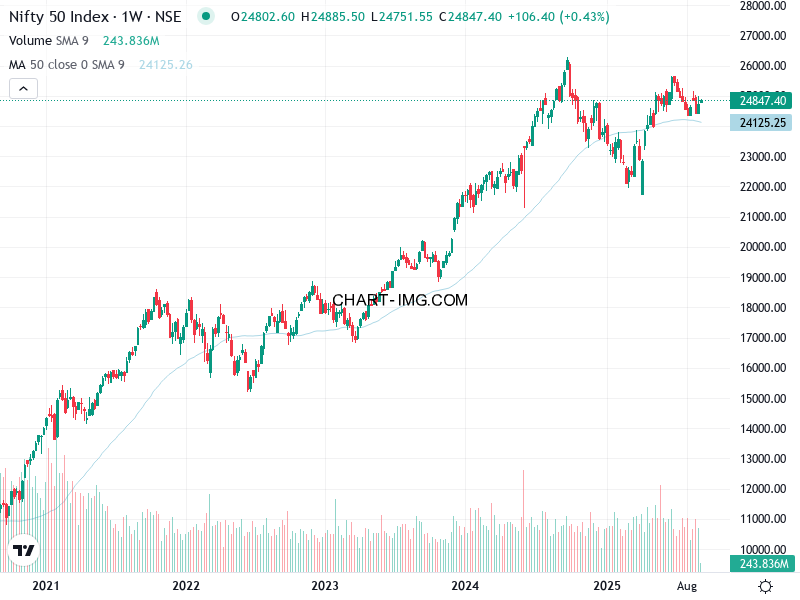

Generating 1M chart for NSE:NIFTY...
Chart image saved successfully as images/1.3 - NIFTY_1M_2025-09-09.png


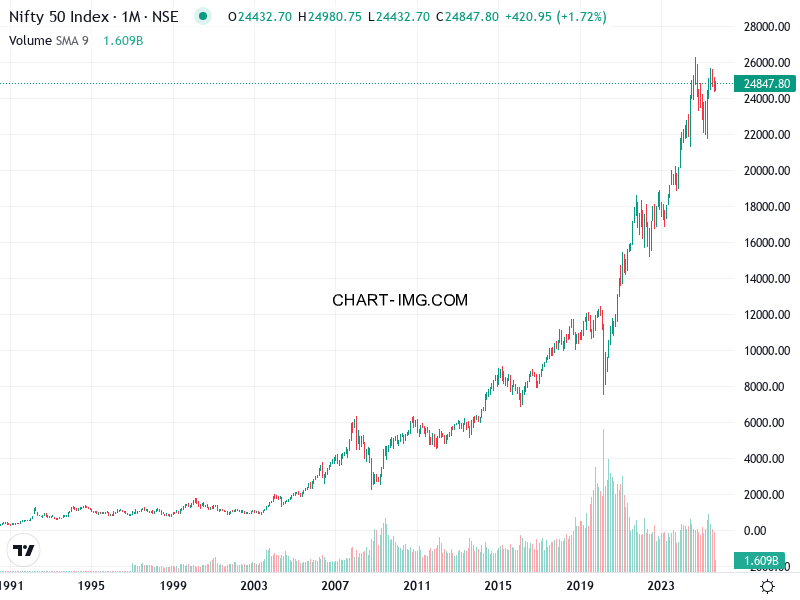

Completed processing NSE:NIFTY
--------------------------------------------------

--- Processing Symbol 2: BSE:NITTAGELA ---
Generating 1D chart for BSE:NITTAGELA...
Chart image saved successfully as images/2.1 - NITTAGELA_1D_2025-09-09.png


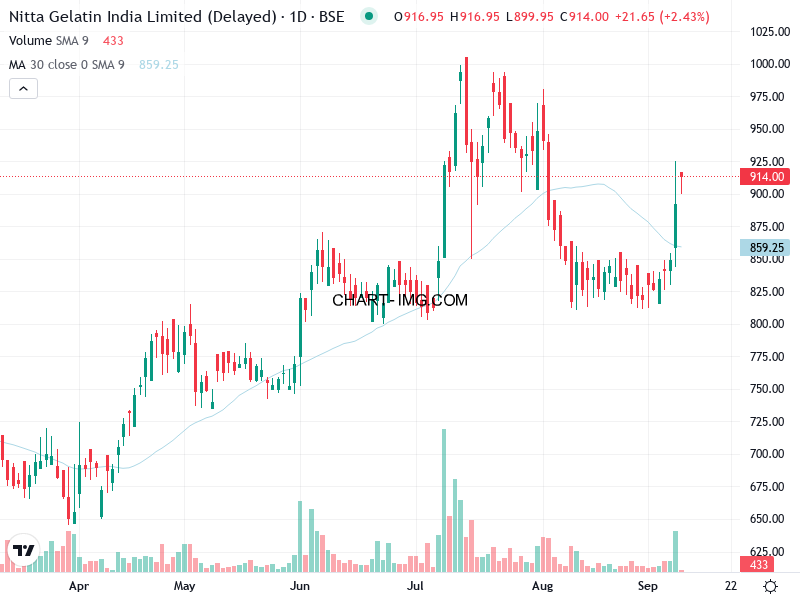

Generating 1W chart for BSE:NITTAGELA...
Chart image saved successfully as images/2.2 - NITTAGELA_1W_2025-09-09.png


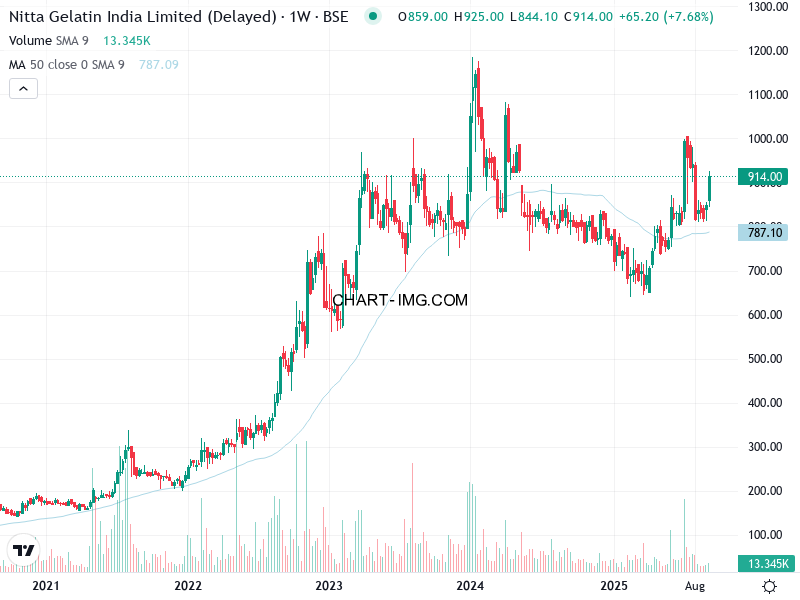

Generating 1M chart for BSE:NITTAGELA...
Chart image saved successfully as images/2.3 - NITTAGELA_1M_2025-09-09.png


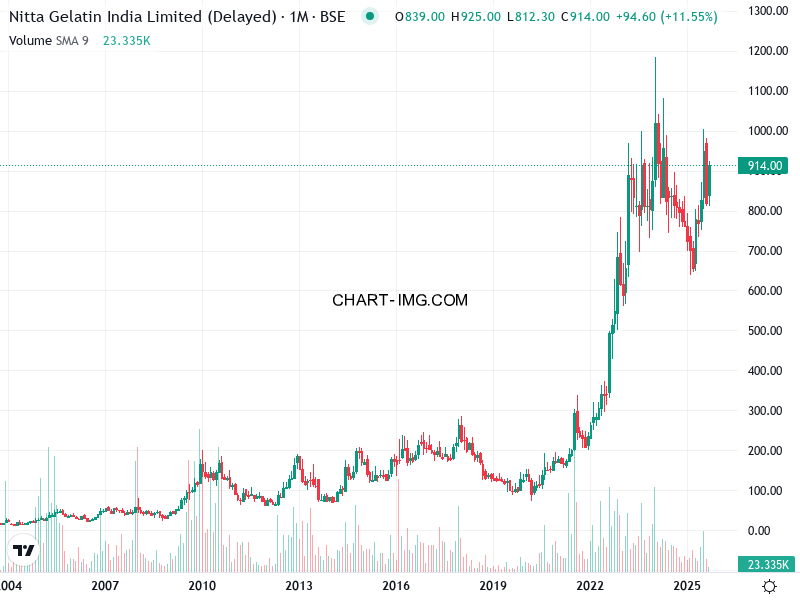

Completed processing BSE:NITTAGELA
--------------------------------------------------

All chart images have been generated successfully!


In [3]:
# Example usage
if __name__ == "__main__":
    # Define your list of stocks
    stocks = ['NSE:NIFTY', 'BSE:NITTAGELA']
    
    # Generate images for all stocks
    generate_images_batch(stocks)
    
    print("\nAll chart images have been generated successfully!")